In [8]:
import xgboost as xgb
from xgboost import plot_importance

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

titanic_df = pd.read_csv('./titanic/titanic_train.csv')
y = titanic_df["Survived"]
feature_name = titanic_df.columns
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [6]:
def fillna(df):
    df['Cabin'] = df['Cabin'].fillna('N')
    df['Embarked'] = df['Embarked'].fillna('N')
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean') #missing_values=np.nan 모든 결측값을 대체한다. / strategy='mean' 평균으로 대체한다.
    age_array = df['Age'].to_numpy().reshape(-1, 1)
    imputer.fit(age_array)
    df['Age'] = imputer.transform(age_array)
    return df


def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)
    print(df.head(3), "\n\n")

    df = df.drop('Survived', axis=1, inplace=False)
    return df


# 레이블
def encode_features_label(df):
    features = ['Cabin', 'Sex', 'Embarked']
    le = LabelEncoder()
    for feature in features:
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df



# 표준화 => 2차원 데이터
def stscaler(df):
    features = ['Age', 'Fare']
    sc = StandardScaler()
    for feature in features:
        df[[feature]] = sc.fit_transform(df[[feature]])
    return df
    

# # 원핫
# # one-hot 인코딩을 하면 많은 0 값을 포함하기 때문에, 이러한 데이터를 희소 행렬 형식으로 저장하면 메모리 사용량을 크게 줄일 수 있다.
# # ColumnTransformer는 인코딩된 데이터를 OneHotEncoder를 통해 처리한 후에 희소 행렬 형태로 반환
# def encode_features_onehot(df):
#     ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1, 6, 7])], remainder='passthrough')
#     df = ct.fit_transform(df)
#     # df = pd.DataFrame(df.toarray()) # 희소 행렬을 Dense 형태로 변환 후 DataFrame으로 변환
#     return df


titanic_df = fillna(titanic_df)
titanic_df = drop_features(titanic_df)

titanic_df = stscaler(titanic_df)

# titanic_df = encode_features_onehot(titanic_df)
titanic_df = encode_features_label(titanic_df)
print(titanic_df[:3])


# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(titanic_df, y, test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리 
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Cabin Embarked
0         0       3    male  22.0      1      0   7.2500     N        S
1         1       1  female  38.0      1      0  71.2833   C85        C
2         1       3  female  26.0      0      0   7.9250     N        S 


   Pclass  Sex       Age  SibSp  Parch      Fare  Cabin  Embarked
0       3    1 -0.592481      1      0 -0.502445    146         3
1       1    0  0.638789      1      0  0.786845     81         0
2       3    0 -0.284663      0      0 -0.488854    146         3


In [9]:
# 만약 구버전 XGBoost에서 DataFrame으로 DMatrix 생성이 안될 경우 X_train.values로 넘파이 변환. 
# 학습, 검증, 테스트용 DMatrix를 생성. 
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test , label=y_test)

params = { 'max_depth':3,
           'eta': 0.05, # learning-rate
           'objective':'binary:logistic', #iteration
           'eval_metric':'logloss'
        }
num_rounds = 400 # n_estermators


# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval' 로 명기합니다. 
eval_list = [(dtr,'train'),(dval,'eval')] # 또는 eval_list = [(dval,'eval')] 만 명기해도 무방. 

# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtr , num_boost_round=num_rounds , \
                      early_stopping_rounds=50, evals=eval_list )

[0]	train-logloss:0.64510	eval-logloss:0.62141
[1]	train-logloss:0.62614	eval-logloss:0.60225
[2]	train-logloss:0.60828	eval-logloss:0.58399
[3]	train-logloss:0.59165	eval-logloss:0.56717
[4]	train-logloss:0.57653	eval-logloss:0.55177
[5]	train-logloss:0.56274	eval-logloss:0.53772
[6]	train-logloss:0.55092	eval-logloss:0.52502
[7]	train-logloss:0.53963	eval-logloss:0.51317
[8]	train-logloss:0.52893	eval-logloss:0.50203
[9]	train-logloss:0.51890	eval-logloss:0.49222
[10]	train-logloss:0.50966	eval-logloss:0.48304
[11]	train-logloss:0.50111	eval-logloss:0.47414
[12]	train-logloss:0.49391	eval-logloss:0.46585
[13]	train-logloss:0.48695	eval-logloss:0.45824
[14]	train-logloss:0.48008	eval-logloss:0.45088
[15]	train-logloss:0.47442	eval-logloss:0.44502
[16]	train-logloss:0.46843	eval-logloss:0.43906
[17]	train-logloss:0.46352	eval-logloss:0.43376
[18]	train-logloss:0.45869	eval-logloss:0.42792
[19]	train-logloss:0.45439	eval-logloss:0.42366
[20]	train-logloss:0.45038	eval-logloss:0.41924
[2

In [10]:
# predict()를 통해 예측 확률값을 반환하고 예측 값으로 변환
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3), "\n")

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.561 0.141 0.147 0.163 0.956 0.139 0.63  0.504 0.132 0.381] 

예측값 10개만 표시: [1, 0, 0, 0, 1, 0, 1, 1, 0, 0]


오차 행렬
[[96 11]
 [22 50]]
정확도: 0.8156, 정밀도: 0.8197, 재현율: 0.6944,    F1: 0.7519, AUC:0.8786




<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

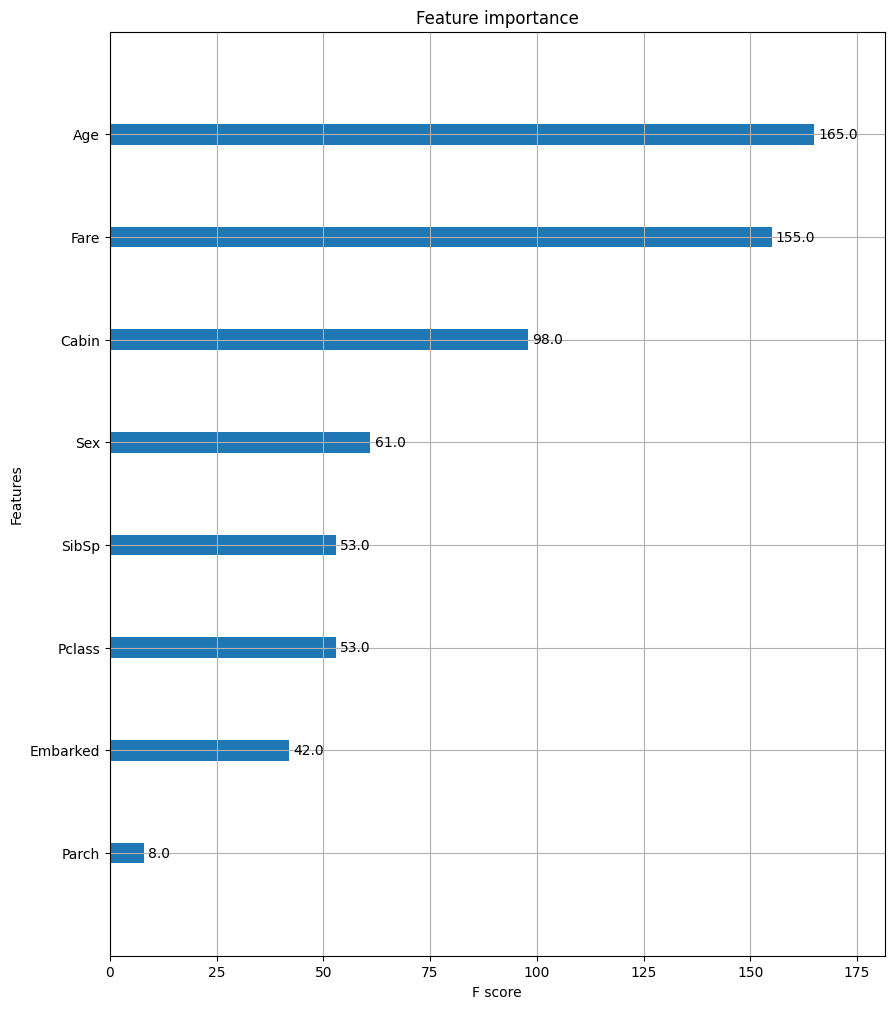

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
%matplotlib inline

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

get_clf_eval(y_test , preds, pred_probs)
print("\n")

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax) # ax가 그림을 그린다.

In [17]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

# Warning 메시지를 없애기 위해 eval_metric 값을 XGBClassifier 생성 인자로 입력. 미 입력해도 수행에 문제 없음.   
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[96 11]
 [18 54]]
정확도: 0.8380, 정밀도: 0.8308, 재현율: 0.7500,    F1: 0.7883, AUC:0.8823


In [18]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", # 학습할 때 early_stopping 적용
                eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.64510	validation_1-logloss:0.62141
[1]	validation_0-logloss:0.62614	validation_1-logloss:0.60225
[2]	validation_0-logloss:0.60828	validation_1-logloss:0.58399
[3]	validation_0-logloss:0.59165	validation_1-logloss:0.56717
[4]	validation_0-logloss:0.57653	validation_1-logloss:0.55177
[5]	validation_0-logloss:0.56274	validation_1-logloss:0.53772
[6]	validation_0-logloss:0.55092	validation_1-logloss:0.52502
[7]	validation_0-logloss:0.53963	validation_1-logloss:0.51317
[8]	validation_0-logloss:0.52893	validation_1-logloss:0.50203
[9]	validation_0-logloss:0.51890	validation_1-logloss:0.49222
[10]	validation_0-logloss:0.50966	validation_1-logloss:0.48304
[11]	validation_0-logloss:0.50111	validation_1-logloss:0.47414
[12]	validation_0-logloss:0.49391	validation_1-logloss:0.46585
[13]	validation_0-logloss:0.48695	validation_1-logloss:0.45824
[14]	validation_0-logloss:0.48008	validation_1-logloss:0.45088
[15]	validation_0-logloss:0.47442	validation_1-logloss:0.44502
[1

/opt/homebrew/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [19]:
get_clf_eval(y_test , ws50_preds, ws50_pred_proba)

오차 행렬
[[95 12]
 [22 50]]
정확도: 0.8101, 정밀도: 0.8065, 재현율: 0.6944,    F1: 0.7463, AUC:0.8683


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

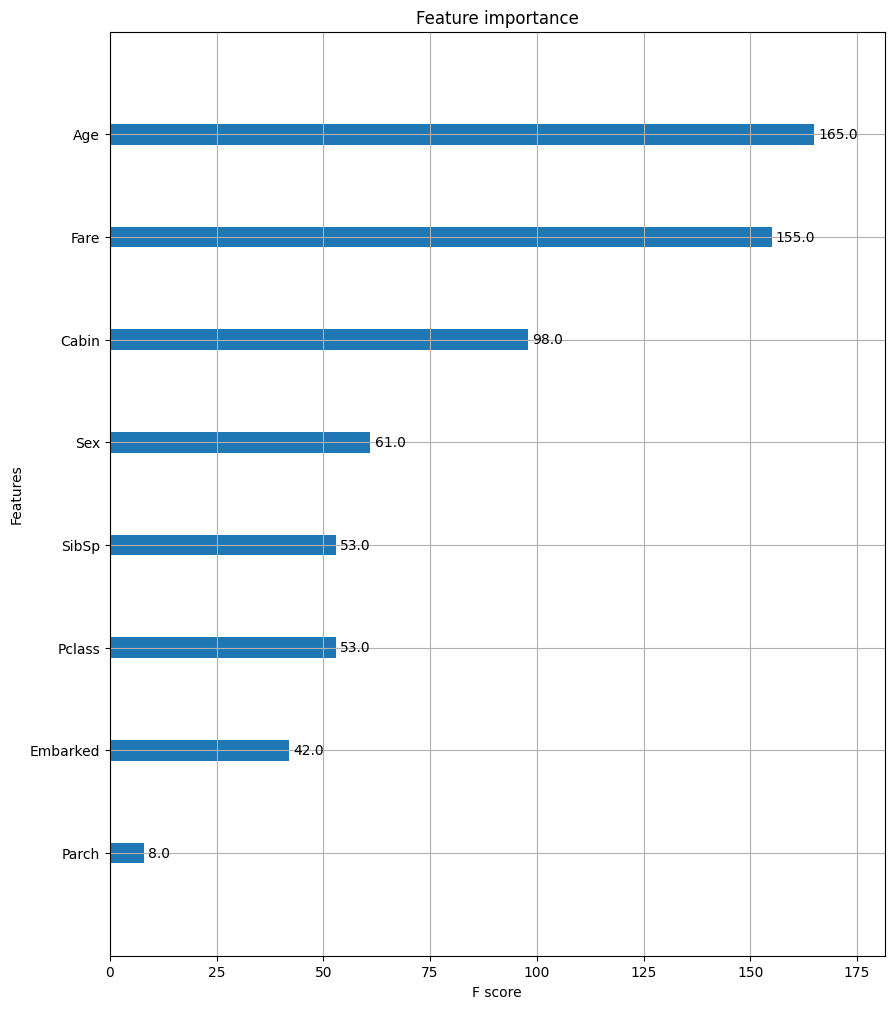

In [20]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)